<a href="https://colab.research.google.com/github/pan825/2025-NSF-HDR-Hachathon/blob/main/HDR_Challange_LIGO_BG_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from scipy.special import expit

# Load my drive to access data and models
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/ligo_transformer_data/challenge/'

# load data and normalize it
background = np.load(os.path.join(data_path, 'background.npz'))['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load(os.path.join(data_path, 'bbh_for_challenge.npy'))
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load(os.path.join(data_path, 'sglf_for_challenge.npy'))
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
signal = np.concatenate((sglf, bbh), axis=0)

anomaly_class = {
    'background': 0,
    'signal': 1
}

background_ids = np.full(background.shape[0], anomaly_class['background'], dtype=int)
signal_ids = np.full(signal.shape[0], anomaly_class['signal'], dtype=int)

x = np.concatenate((background, signal), axis=0).reshape((-1,200,2))
y = np.concatenate((background_ids, signal_ids), axis=0)

# mix events
idx = np.random.permutation(len(x))
x, y = x[idx], y[idx]


In [ ]:
# load data and normalize it
def normalize_data(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data - mean) / std

assert background.shape == bbh.shape
combined_data = background + bbh
combined_data = normalize_data(combined_data)

In [ ]:
# Create train and test datasets

x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)
y train/test shapes: (80000, 200, 2) (20000, 200, 2)


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.special import expit


class Model:
    def __init__(self):
        super().__init__()

    def encoder(self, inputs):
        x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(inputs)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Conv1D(16, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Conv1D(16, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Flatten()(x)
        x = layers.Dense(400, activation="relu")(x)
        return x

    def decoder(self, inputs, original_shape):
        x = layers.Dense(1600, activation="relu")(inputs)
        x = layers.Reshape((25, 64))(x)
        x = layers.Conv1D(16, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.UpSampling1D(size=2)(x)
        x = layers.Conv1D(16, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.UpSampling1D(size=2)(x)
        x = layers.Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
        x = layers.UpSampling1D(size=2)(x)
        x = layers.Conv1D(2, kernel_size=3, padding="same", activation="sigmoid")(x)
        return x

    def build_model(self, input_shape):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        encoded = self.encoder(inputs)

        # Decoder
        decoded = self.decoder(encoded, input_shape)

        # Autoencoder Model
        self.ae = keras.Model(inputs, decoded)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-5))

    def predict(self, X, batch_size=32):
        reconstruction_error = np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1, 2))
        probabilities = expit(-reconstruction_error)
        return probabilities

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history



In [ ]:
# Example usage:
input_shape = (200, 2)  # Updated input data shape

# Build the model
autoencoder = Model()
autoencoder.build_model(input_shape=input_shape)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
# Assuming x_train and x_test are your input data
history = autoencoder.fit(
    x_train,  # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True), reduce_lr]
)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.0920 - val_loss: 1.0005 - learning_rate: 1.0000e-05
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005 - learning_rate: 1.0000e-05
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005 - learning_rate: 1.0000e-05
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0004 - val_loss: 0.9960 - learning_rate: 1.0000e-05
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9778 - val_loss: 0.9561 - learning_rate: 1.0000e-05
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9526 - val_loss: 0.9422 - learning_rate: 1.0000e-05
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9392 - val_loss: 0.9328 - learning_rate: 1.0000e-05
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9312 - val_loss: 0.9269 - learning_rate: 1.0000e-05
Epoch 9/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 

In [ ]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model


In [ ]:
autoencoder.save('')

In [ ]:
autoencoder.load()

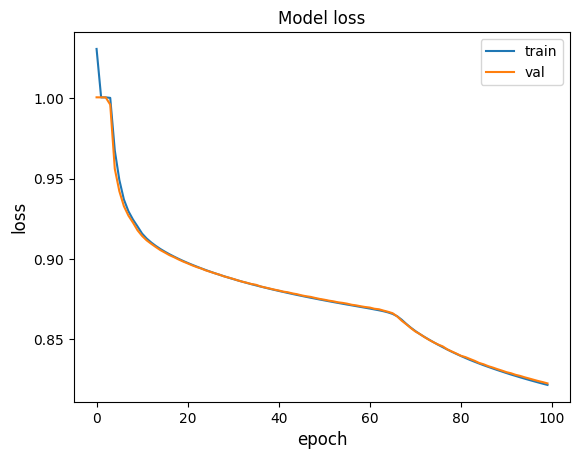

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
TNR: 0.9807


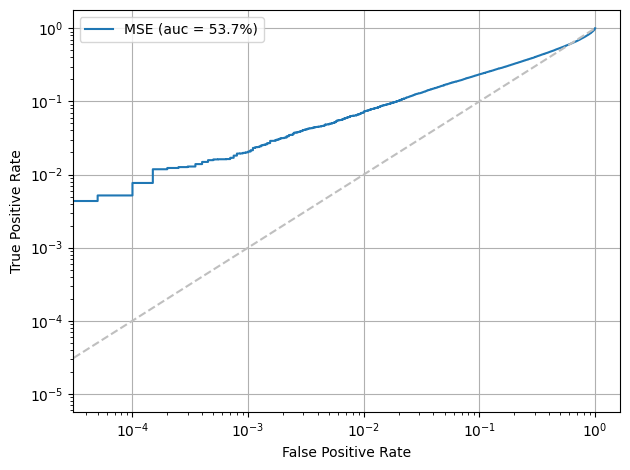

Final TNR: 0.9807


In [ ]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

from sklearn.metrics import confusion_matrix

def compute_tnr(qcd, bsm):
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    threshold = np.percentile(pred_val[true_val == 1], 90)
    binary_pred = (pred_val >= threshold).astype(int)

    tn, fp, fn, tp = confusion_matrix(true_val, binary_pred).ravel()
    tnr = tn / (tn + fp)

    return tnr

def make_plot_roc_curves_and_tnr(qcd, bsm):
    """
    Plot ROC curve and compute TNR.
    """
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    # Compute ROC curve and AUC
    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Compute TNR
    tnr = compute_tnr(qcd, bsm)
    print(f"TNR: {tnr:.4f}")

    # Sort qcd values for ROC curve
    qcd[::-1].sort()

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)' % (auc_loss * 100.),
             linewidth=1.5)
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return tnr


# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

tnr = make_plot_roc_curves_and_tnr(background_test, signal_test)
print(f"Final TNR: {tnr:.4f}")

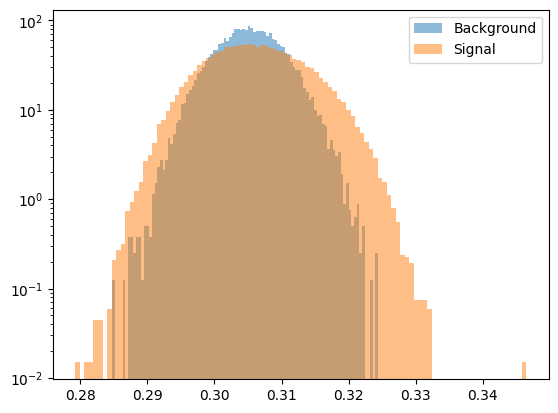

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
pretrained_model = Model()
pretrained_model.load()

# Check its architecture
pretrained_model.ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200, 2)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 200, 128)            │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 100, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 100, 16)             │           6,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 50, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 50, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 25, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 400)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1600)                │         641,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 25, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 25, 16)              │           3,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d (UpSampling1D)         │ (None, 50, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 50, 16)              │             784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_1 (UpSampling1D)       │ (None, 100, 16)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 100, 128)            │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling1d_2 (UpSampling1D)       │ (None, 200, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 200, 2)              │             770 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,462,264 (9.39 MB)

 Trainable params: 820,754 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,641,510 (6.26 MB)

In [ ]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 1.4570 - val_loss: 0.8228
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7541 - val_loss: 0.6196
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5566 - val_loss: 0.4632
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4658 - val_loss: 0.4190
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4157 - val_loss: 0.3839
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3833 - val_loss: 0.3574
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3587 - val_loss: 0.3279
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3387 - val_loss: 0.3108
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3274 - val_loss: 0.3036
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3126 - val_loss: 0.2932
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2949 - val_loss: 0.2688
Epoch 12/50
2000/2000 ━━━━━━━

In [ ]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')